In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from statsmodels.tsa.stattools import adfuller#, kpss
#from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import collections
import itertools
from itertools import product
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
#import sys


C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
alldata = pd.read_csv('train.csv', header=0, parse_dates=True, index_col=2)

In [4]:
alldata.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [5]:
alldata.tail()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2012-09-28,45,98,508.37,False
2012-10-05,45,98,628.10,False
2012-10-12,45,98,1061.02,False
2012-10-19,45,98,760.01,False
2012-10-26,45,98,1076.80,False


In [6]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 4 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), float64(1), int64(2)
memory usage: 13.3 MB


In [7]:
stores_all = alldata['Store'].unique()
depts_all = alldata['Dept'].unique()

### EDA

In [8]:
## define a function to visualize the sales data for stores and depts

def eda_sales(df, store_locations, departments):
    nrow = len(store_locations)
    ncol = len(departments)
    
    fig,ax = plt.subplots(nrow,ncol)
    r = 0
    c = 0
    
    for store in store_locations:
        c = 0
        for dept in departments:
            df_str_dept = df[(df['Store']==store) & (df['Dept']==dept)][['Weekly_Sales']]
            df_str_dept['Weekly_Sales'].plot(ax=ax[r,c], sharey=True,figsize=(18,18),title='Weekly Sales for Store %d - Dept %d' %(store,dept))        
            c += 1
            plt.tight_layout()
                                               
        r += 1                                 
    

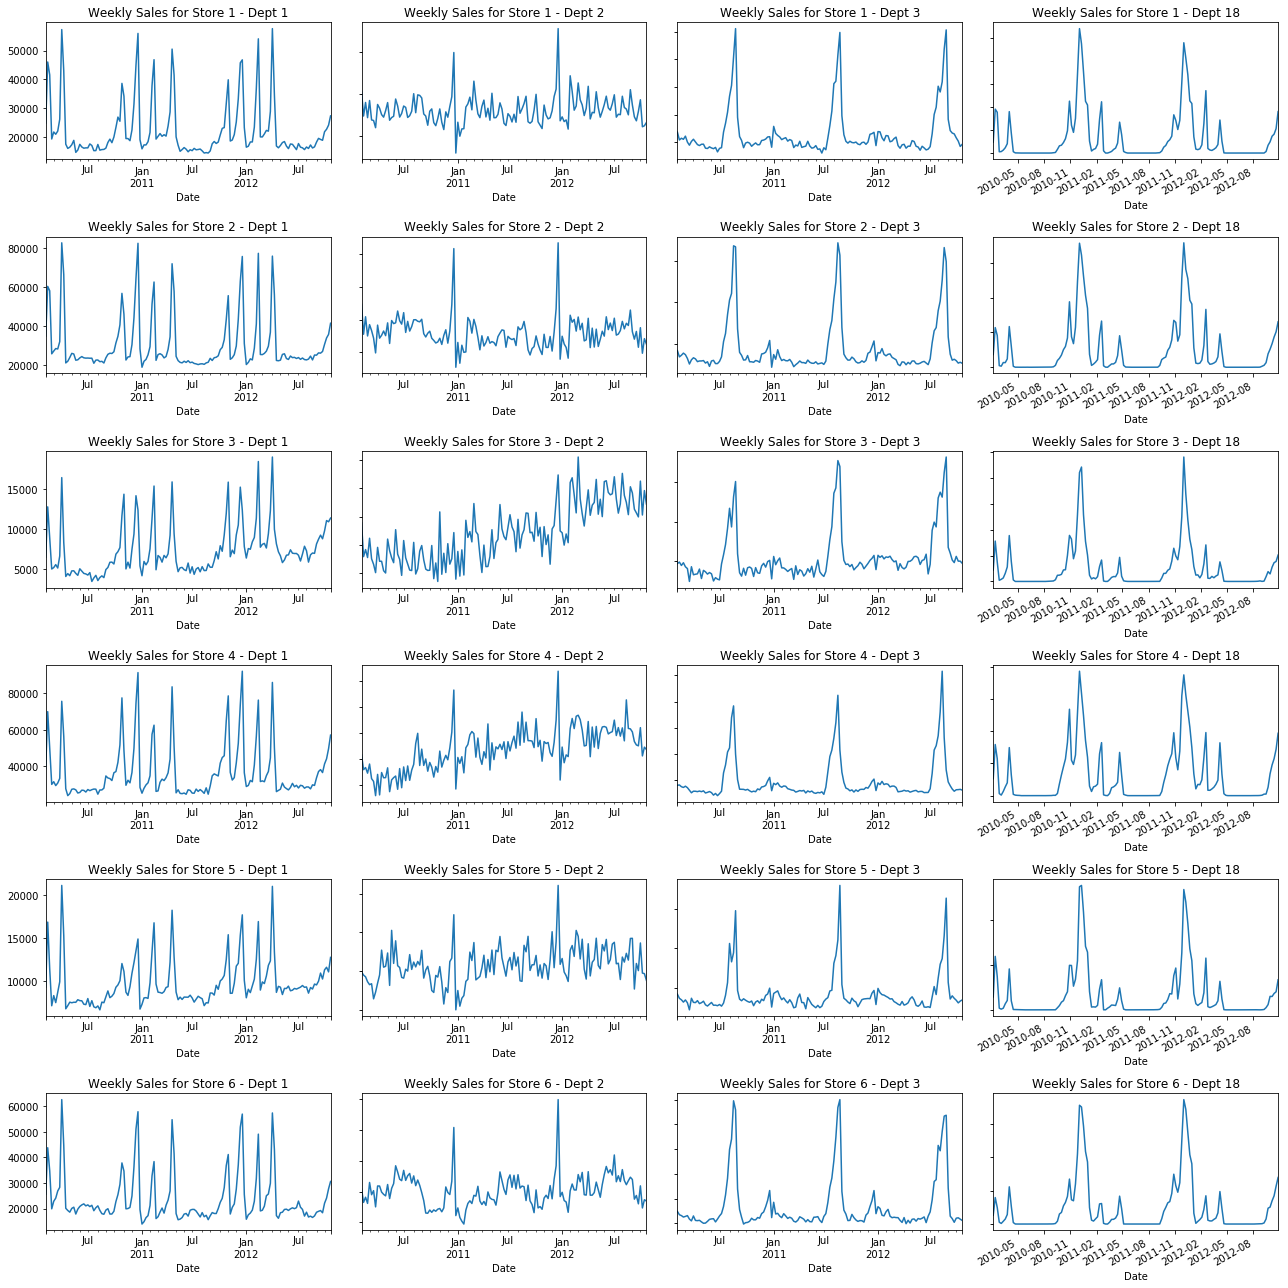

In [9]:
eda_sales(alldata,store_locations=[1,2,3,4,5,6],departments=[1,2,3,18])

In [10]:
## The graph sales of given departments in the different stores look similar.
## Eg. Dept 1 in Stores 1 through 6 have similar spikes/seasonality

In [11]:
## Augmented Dickey Fuller test to check stationarity of time series:
def adf_test(df, store_locations, departments):
    adf_results = collections.defaultdict(list)
    
    for store in store_locations:
        for dept in departments:
            df_str_dept = df[(df['Store']==store) & (df['Dept']==dept)][['Weekly_Sales']]
            y = df_str_dept['Weekly_Sales']
            dftest = adfuller(y, autolag='AIC')            
            adf_results[(store,dept)].append('Test Statistic: ''%f' %(dftest[0]))
            adf_results[(store,dept)].append('p-value: ''%f' %(dftest[1]))
            adf_results[(store,dept)].append('#Lags used: ''%d' %(dftest[2]))
            adf_results[(store,dept)].append("Number of observations used: '%d'" %(dftest[3]))
            adf_results[(store,dept)].append("Critical Values: ")
            for k, v in dftest[4].items():
                adf_results[(store,dept)].append('%s : ''%.3f' %(k,v))
                if (k == '5%') & (dftest[0] > v) & (dftest[1] > 0.05):  
                    adf_results[(store,dept)].append('****** Take First diff ******')                    
            
    return adf_results

In [12]:
result = adf_test(alldata,store_locations=[1],departments=[1])

In [13]:
result

defaultdict(list,
            {(1, 1): ['Test Statistic: -2.522164',
              'p-value: 0.110174',
              '#Lags used: 6',
              "Number of observations used: '136'",
              'Critical Values: ',
              '1% : -3.479',
              '5% : -2.883',
              '****** Take First diff ******',
              '10% : -2.578']})

### ARIMA

In [14]:
## We can use the ARIMA (autoregressive integrated moving average) model to fit the time series data 
## in order to predict future points in the series.

In [15]:
## There are three distinct integers (p, d, q) that are used to parametrize ARIMA models.
## These three parameters account for seasonality, trend, and noise in datasets

## p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model.
## d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing.
## q is the moving average part of the model. This allows us to set the error of our model as a 
## linear combination of the error values observed at previous time points in the past.

In [16]:
## Since we have time series with seasonal effects, we can use the seasonal ARIMA,
## which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the non-seasonal parameters, 
## while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. 
## The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

In [17]:
def plot_acf_pacf(df,store_locations,departments,lags=10):
    nrow = len(store_locations)*2
    ncol = len(departments)
    
    fig,ax = plt.subplots(nrow,ncol,figsize=(12,8))
    r = 0
    c = 0
    for store in store_locations:
        c=0
        for dept in departments:
            df_str_dept = df[(df['Store']==store) & (df['Dept']==dept)][['Weekly_Sales']]
            y = df_str_dept['Weekly_Sales']
            smt.graphics.plot_acf(y, lags=10,title='Autocorrelation for Store %d, Dept %d' %(store,dept),ax=ax[r,c])
            smt.graphics.plot_pacf(y, lags=10,title='Partial Autocorrelation for Store %d, Dept %d' %(store,dept),ax=ax[r,c+1]);            
            r += 1
            plt.tight_layout()

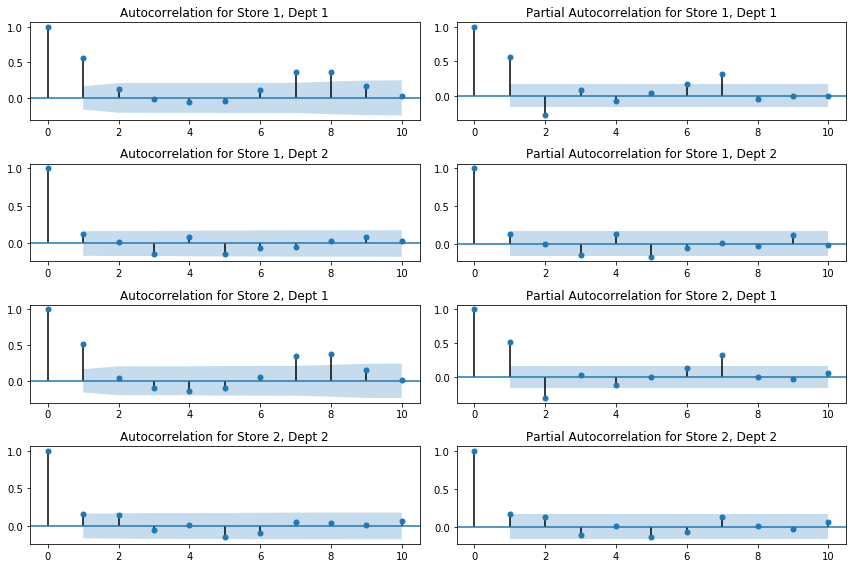

In [18]:
plot_acf_pacf(alldata,store_locations=[1,2],departments=[1,2])

In [19]:
### Looking at Store 1, Dept 1:
## From PACF: since the first significant spike in the blue shaded area is at 2 (negative correlation),
## we can say that the p = 2
## From ACF: since the first significant spike iin the blue shaded area is ar 2, we can say that q = 2
## And since ADF test showed that the times series became stationary when taking the 1st difference, d = 1.

## So, lets use the range(0,2) to come up with the optimal parameters for p and q using grid search

In [20]:
def forecast_sales(df, store_locations, departments):
    
    pdq_dict = collections.defaultdict(list)    
    result_dict = collections.defaultdict(list)   
    
    
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]    
    
    for store in store_locations:
        for dept in departments:
            df_str_dept = df[(df['Store']==store) & (df['Dept']==dept)][['Weekly_Sales']]
            
            ## Find if there are missing dates in the df_str_dept df
               ## Get the date ranges in the df with all stores/depts
            daterange = pd.date_range(start=df.index.min().date(),end=df.index.max().date(), freq='W-FRI')             
               
            #df_str_dept.set_index('ds',inplace=True)
            missing = sorted(set(daterange)  - set(df_str_dept.index))            
            
            if(len(missing) > 1):                
                df_str_dept = df_str_dept.reindex(daterange, fill_value=0) ## fill missing weekdays with 0
                y = df_str_dept['Weekly_Sales']                
            else:                
                y = df_str_dept['Weekly_Sales']
            
            best_aic = np.inf
            best_pdq = None
            best_seasonal_pdq = None
            tmp_model = None
            best_mdl = None
            
            ##Split train and test data
            train_size = int(len(y) * 0.70)
            y_train, y_test = y[0:train_size], y[train_size:len(y)]
            
            for param in pdq:
                for param_seasonal in seasonal_pdq:
                    try:
                        tmp_mdl = sm.tsa.statespace.SARIMAX(y_train,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity=True,
                                                enforce_invertibility=True)
                        res = tmp_mdl.fit()
                        if res.aic < best_aic:
                            best_aic = res.aic
                            best_pdq = param
                            best_seasonal_pdq = param_seasonal
                            best_mdl = tmp_mdl
                    except:
           # print("Unexpected error:", sys.exc_info()[0])
                        continue
            pdq_dict[(store, dept)].append(best_pdq)
            pdq_dict[(store, dept)].append(best_seasonal_pdq)
            pdq_dict[(store, dept)].append(best_aic)
            
            model = sm.tsa.statespace.SARIMAX(y_train, order = best_pdq,seasonal_order = best_seasonal_pdq
                                              ,enforce_stationarity=True
                                              ,enforce_invertibility=True)
            result = model.fit()
            result.summary()
            
            
            ## Out of sample prediction
            ## Predict for train_df and test_df timeframe
            forecast_out = result.predict(start=pd.to_datetime(y_train.index[0].date()), 
                              end=pd.to_datetime(y_test.index[-1].date()),
                              dynamic=False, full_results=True)
            
            ## Create metrics_df that holds forecasted values for test_df timeframe and original test_df
            metrics_df = pd.concat((forecast_out[y_test.index[0]:y_test.index[-1]], y_test), axis=1)
            metrics_df.columns = ['y_hat', 'y_true']            
            
            mse = mean_squared_error(metrics_df['y_true'], metrics_df['y_hat'])
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(metrics_df['y_true'], metrics_df['y_hat'])
            
            result_dict[(store,dept)].append(rmse)
            result_dict[(store,dept)].append(mae)
            
    return result_dict

In [21]:
forecast_result = forecast_sales(alldata, store_locations=[1,2,3,4,5],departments=[1,2,3,18])

C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [22]:
forecast_result ## Store, Dept, rmse, mae

defaultdict(list,
            {(1, 1): [8549.0711845748283, 3564.3695882292382],
             (1, 2): [6470.7823036175359, 6159.8298891831537],
             (1, 3): [5290.793636035939, 2378.1605989914406],
             (1, 18): [3266.1083689859956, 1670.1242090666908],
             (2, 1): [14114.751588092075, 9006.1068266230486],
             (2, 2): [3105.7180944066818, 2526.1003621284844],
             (2, 3): [6170.3597737978653, 3142.2658970426501],
             (2, 18): [4763.0448502966456, 2884.516405338848],
             (3, 1): [2517.7278923526101, 1396.8044150940732],
             (3, 2): [1365.4445467990945, 1138.2561696184034],
             (3, 3): [1907.1660062427632, 1014.0119211343706],
             (3, 18): [1219.381847020655, 884.41339105694306],
             (4, 1): [12773.464278239891, 6003.5811399637796],
             (4, 2): [4185.4003040432663, 3343.7758165136033],
             (4, 3): [3880.8705656685611, 2126.6952688674442],
             (4, 18): [7774.028912904